### Hypothesis Testing

- classical p-value
- sequential A/B testing

E_cr - conversion rate for exposed group

C_cr - conversion rate for control group - baseline conversion

In [1]:
import imp
import sys
import os
import pandas as pd
import numpy as np
import math
from math import factorial
import logging

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("../scripts")))
from DistributionPlots import DistributionPlots
DP = DistributionPlots()

from ABTestingFunctions import ABTesting
ABT = ABTesting()
 
 
from sequential_testing_helper import Sequential_AB_Helper
seq = Sequential_AB_Helper()

import data_loader
import ploting_utils
import hypothesis_test


In [2]:
logging.basicConfig(filename='../logfile.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)


In [3]:
df = data_loader.load_data('../data/ABtwoCampaignEngView.csv')
df

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,1333639,8ec30aff-2332-4a1f-9330-b93abb32bc94,control,<built-in method date of Timestamp object at 0...,15,LG,156,6,0.0,0.0
1,730667,4e1bcb56-357c-4186-9d39-3be82e3519f1,control,<built-in method date of Timestamp object at 0...,7,Samsung,162,6,0.0,0.0
2,2069787,dd6ec327-fcfd-4a80-89c0-dccd3dd80f09,control,<built-in method date of Timestamp object at 0...,14,Apple,178,15,0.0,0.0
3,1692366,b5222d0f-39e3-4c02-a12f-1ef09d4f861f,control,<built-in method date of Timestamp object at 0...,22,Apple,167,15,0.0,0.0
4,1384123,9428377d-1504-4407-87c2-ce518f67eb87,control,<built-in method date of Timestamp object at 0...,21,Samsung,155,15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
912707,1426994,98c10ba3-932f-4feb-ad01-d1b549dbd905,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,162,15,0.0,1.0
912708,1846194,c591dcc1-2526-4caa-8561-0f9da1fe565b,exposed,<built-in method date of Timestamp object at 0...,8,Samsung,162,15,0.0,0.0
912709,2133458,e44046fa-0d3e-4680-99a8-f8d2167890f4,exposed,<built-in method date of Timestamp object at 0...,5,Apple,101,7,0.0,0.0
912710,1815799,c25657c2-f1b6-4f50-9610-9f3bbef2594d,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,101,6,1.0,0.0


In [4]:
ddf = df.groupby('experiment').agg(
    {'auction_id': 'count', 'yes': 'sum', 'no': 'sum'}).reset_index()
ddf = ddf.rename(columns={'auction_id': 'total'})
ddf


,experiment,total,yes,no
0,control,456356,10641.0,8258.0
1,exposed,456356,82132.0,9539.0


In [5]:
C_total = ddf.total.iloc[0]
E_total = ddf.total.iloc[1]

In [6]:
C_aware = ddf.yes.iloc[0]
E_aware = ddf.yes.iloc[1]


In [7]:
C_cr = ddf.yes.iloc[0]/ddf.total.iloc[0]
E_cr = ddf.yes.iloc[1]/ddf.total.iloc[1]

print('convertion rate for contro gruop = {}%'.format(C_cr))
print('convertion rate for exposed gruop = {}%'.format(E_cr))


convertion rate for contro gruop = 0.023317322441252005%
convertion rate for exposed gruop = 0.17997352943754438%


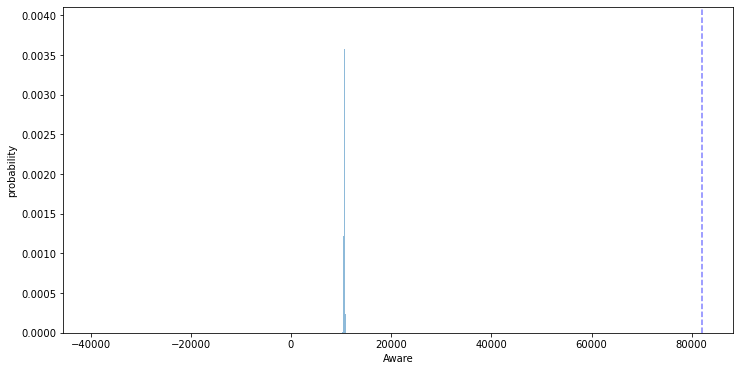

In [8]:
#control group distribution with probability of getting the result from our exposed group
DP.cont_distribution(C_aware, C_total, C_cr, E_cr)

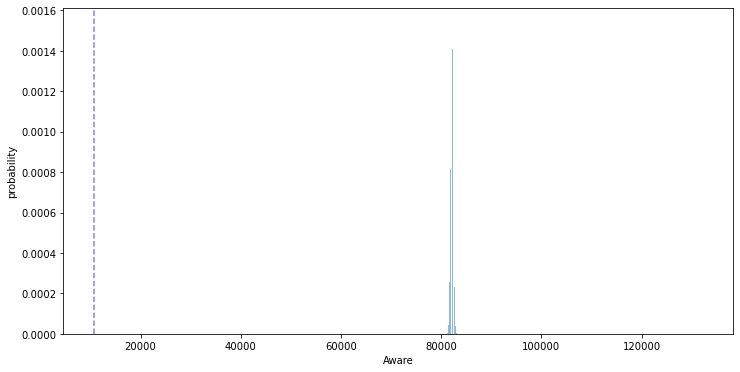

In [9]:
#control group distribution with probability of getting the result from our exposed group
DP.cont_distribution(E_aware, E_total, E_cr, C_cr)


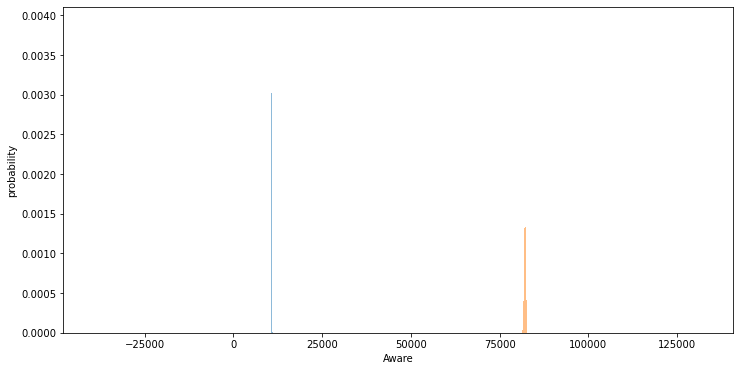

In [10]:
#comparison of control and exposed groups distribution against each other
DP.cont_exp_distribution(C_aware, E_aware, C_total, E_total, C_cr, E_cr)

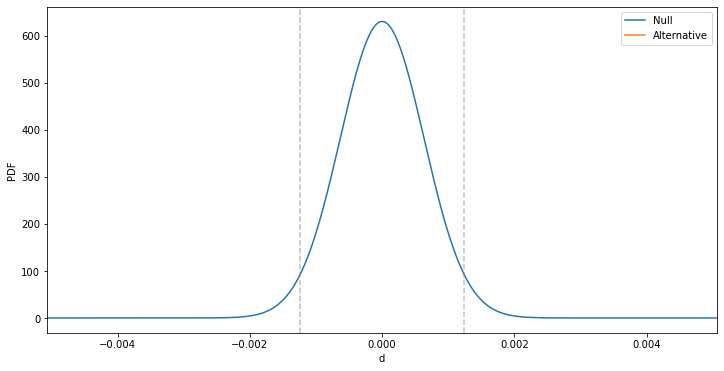

In [11]:
#Null and alternative hypotheses plots with
#statistical power and significance levels defined and represented in the plots
DP.null_alt_distribution(C_total, E_total, C_cr, E_cr)

In [12]:
# ABT.p_val(ddf.yes.iloc[0],  ddf.yes.iloc[1], C_cr, E_cr)


## classical p-value

In [13]:
zscore, pvalue = hypothesis_test.two_proprotions_test(
    ddf.yes.iloc[0], ddf.total.iloc[0],  ddf.yes.iloc[1], ddf.total.iloc[1])
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))


zscore = 247.638, pvalue = 0.000


***Assuming 95% confidence level, the new advertising is more successful.
p_vlaue = 0.00*** 

# sequential

In [14]:

from ctypes import c_wchar
import numpy as np

print('E-C = {}'.format(E_aware-C_aware))
print('E+C = {}'.format(E_aware+C_aware))
print('N = {}'.format(ddf.total.sum()))
print('2*sqrt(N) = {}'.format(2*np.sqrt(ddf.total.sum())))


E-C = 71491.0
E+C = 92773.0
N = 912712
2*sqrt(N) = 1910.7192363086733


- If (T-C) reaches (2*sqrt{N}), stop the test. Declare the treatment to be the winner.
- If (T+C) reaches (N), stop the test. Declare no winner.

## Conclusion 
- According to Even Miller Sequential A/B test:
    - If (T-C) reaches (2*sqrt{N}), stop the test. Declare the treatment to be the winner.
    - If (T+C) reaches (N), stop the test. Declare no winner.
It is possible to reach a conclusion, we do not need additional data. The new ad is winner

- Based on the classical test, the p-value is lessan than 0.05, we reject the null hypothesis and accepth the alternative.
- The newly designed ad has increased the brand awareness

